In [379]:
import cv2
from IPython.display import clear_output, Video

import matplotlib.pyplot as plt
import numpy as np
from typing import *
from time import sleep
from PIL import Image

In [329]:
DATA_PATH = "../data/my_dataset"
VIDEO_PATH = f"{DATA_PATH}/rgb/video.mp4"
! ls {VIDEO_PATH}

../data/my_dataset/rgb/video.mp4


Executing <Handle IOLoop._run_callback(functools.par...ueues.py:217>)) created at /home/ay/.local/lib/python3.7/site-packages/tornado/platform/asyncio.py:154> took 0.158 seconds


In [330]:
vid = cv2.VideoCapture(VIDEO_PATH)
vid.set(cv2.CAP_PROP_POS_AVI_RATIO,1)
vid.get(cv2.CAP_PROP_FRAME_COUNT)

210.0

In [331]:
def play_video(video_path: str):
    vid = cv2.VideoCapture(video_path)
    try:
        ret, frame = vid.read()

        while ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            plt.axis('off')
            plt.title("Input Stream")
            plt.imshow(frame)
            plt.show()
            clear_output(wait=True)

            ret, frame = vid.read()

    except KeyboardInterrupt:
        pass
    finally:
        vid.release()

play_video(VIDEO_PATH)

Executing <Handle IOLoop._run_callback(functools.par...ueues.py:217>)) created at /home/ay/.local/lib/python3.7/site-packages/tornado/platform/asyncio.py:154> took 12.143 seconds


In [332]:
vid = cv2.VideoCapture(VIDEO_PATH)

In [333]:
def get_video_fps(vid):
    return vid.get(cv2.CAP_PROP_FPS)

fps = get_video_fps(vid)
fps

30.0

In [334]:
def get_video_size(vid):
    w = vid.get(cv2.CAP_PROP_FRAME_WIDTH)
    h = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
    return int(w), int(h)

frame_size = get_video_size(vid)
frame_size

(256, 224)

In [335]:
def get_video_writer(out_path: str, *, fps, frame_size):
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    return cv2.VideoWriter(out_path, fourcc, fps, frame_size)

vid_writer = get_video_writer("/tmp/output.mp4", fps=fps, frame_size=frame_size)
vid_writer

<VideoWriter 0x7fc3ca288e50>

In [337]:
def get_frame(vid, ms: int):
    # Note: sets pointer in 'vid' to 'ms'
    assert vid.isOpened(), vid
    vid.set(cv2.CAP_PROP_POS_MSEC, ms)
    ret, frame = vid.read()
    if not ret:
        # EOF
        return None
    return frame


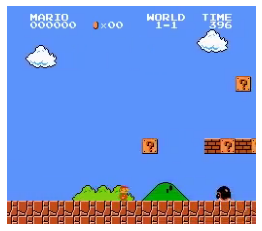

Executing <Handle IOLoop._run_callback(functools.par...ueues.py:217>)) created at /home/ay/.local/lib/python3.7/site-packages/tornado/platform/asyncio.py:154> took 0.177 seconds


In [371]:
def imshow(frame: np.ndarray, name: Optional[str] = None):
    if name:
        plt.title(name)
    plt.axis('off')
    frame = frame[:, :, ::-1]
    plt.imshow(frame)
    plt.show()

frame = get_frame(vid, 2000)  # out of 6_984
imshow(frame)

In [388]:
def iter_frames(vid, *, from_ms: int = 0, to_ms: Optional[int] = None, speed: int = 1):
    assert speed >= 1, ("invalid speed", speed)
    #if step_ms is not None:
        #min_step_ms = int(1_000 / get_video_fps(vid))
        #if step_ms < min_step_ms:
        #    raise ValueError(f"Invalid step_ms={step_ms}: min value is {min_step_ms}")
        
    vid.set(cv2.CAP_PROP_POS_MSEC, from_ms)
    ret, frame = vid.read()
    
    while ret:
        ms = vid.get(cv2.CAP_PROP_POS_MSEC)
        
        yield int(ms), frame
        
        if to_ms is not None and ms >= to_ms:
            break
        if speed > 1:
            fr = vid.get(cv2.CAP_PROP_POS_FRAMES)
            vid.set(cv2.CAP_PROP_POS_FRAMES, fr + speed - 1)
            #vid.set(cv2.CAP_PROP_POS_MSEC, ms + step_ms)

        ret, frame = vid.read()

In [393]:
# Generate mock depth-channel images:

base_path = "../data/my_dataset/depth"
N = 6
speed = 20

for i, (ms, frame) in enumerate(iter_frames(vid, from_ms=1_000, speed=speed)):
    frame = frame[:, :, ::-1]  # let it be inverted colors
    #imshow(frame)
    _id = str(i).zfill(6)
    name = f"{base_path}/frame-{_id}.png"
    pil_img = Image.fromarray(frame)
    pil_img.save(name)
    print(f"{ms:09} {_id}")  # format of depth/per_frame_timestamps.txt
    if i == N-1:
        break

000001000 000000
000001666 000001
000002333 000002
000003000 000003
000003666 000004
000004333 000005
000005000 000006


Executing <Handle IOLoop._run_callback(functools.par...ueues.py:217>)) created at /home/ay/.local/lib/python3.7/site-packages/tornado/platform/asyncio.py:154> took 0.285 seconds


In [402]:
# For rbg data, we'll use 10 frames starting from 1 sec with speed=3
N = 10
speed = 3

for i, (ms, frame) in enumerate(iter_frames(vid, from_ms=1_000, speed=speed)):
    _id = str(i).zfill(6)
    print(f"{ms:09} {_id}")
    #imshow(frame)
    if i == N-1:
        break

000001000 000000
000001100 000001
000001200 000002
000001300 000003
000001400 000004
000001500 000005
000001600 000006
000001700 000007
000001800 000008
000001900 000009


Executing <Handle IOLoop._run_callback(functools.par...ueues.py:217>)) created at /home/ay/.local/lib/python3.7/site-packages/tornado/platform/asyncio.py:154> took 0.148 seconds


In [315]:
def dump_video(in_path: str, out_path: str, *, from_ms: int = 0, to_ms: Optional[int] = None, speed: int = 1):
    vid = cv2.VideoCapture(in_path)
    vid_writer = None
    try:
        fps = get_video_fps(vid)
        frame_size = get_video_size(vid)
        vid_writer = get_video_writer(out_path, fps=fps, frame_size=frame_size)

        count = 0
        for frame in iter_frames(vid, from_ms=from_ms, to_ms=to_ms, speed=speed):
            vid_writer.write(frame[:, :, ::-1])
            count += 1
        print(f"Written {count} frames to file '{out_path}'")
    finally:
        if vid_writer:
            vid_writer.release()
        
dump_video(VIDEO_PATH, "/tmp/out.mp4", from_ms=1_000, to_ms=7_000, speed=2)
!ls -l /tmp/out.mp4

Written 90 frames to file '/tmp/out.mp4'
-rw-r--r-- 1 ay ay 324380 Jul 30 19:54 /tmp/out.mp4


Executing <Handle IOLoop._run_callback(functools.par...ueues.py:217>)) created at /home/ay/.local/lib/python3.7/site-packages/tornado/platform/asyncio.py:154> took 3.475 seconds
